In [ ]:
import os
import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import string
from collections import Counter

In [ ]:
data = pd.read_csv('https://query.data.world/s/lr65wdo52sbef23dnicwww2fjpuure')
print(data.shape)
data.head()

(2052781, 5)


,name,sex,year,rank,count
0,John,M,1880,1.0,9655
1,Mary,F,1880,1.0,7065
2,John,M,1881,1.0,8769
3,Mary,F,1881,1.0,6919
4,John,M,1882,1.0,9557


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2052781 entries, 0 to 2052780
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   name    object 
 1   sex     object 
 2   year    int64  
 3   rank    float64
 4   count   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 78.3+ MB


In [ ]:
def clean(name):
    name = name.lower().strip()
    name = "".join([c for c in name if c in string.ascii_lowercase])
    name += "."
    return name

In [ ]:
data['name'] = data['name'].apply(clean)
data.head()

,name,sex,year,rank,count
0,john.,M,1880,1.0,9655
1,mary.,F,1880,1.0,7065
2,john.,M,1881,1.0,8769
3,mary.,F,1881,1.0,6919
4,john.,M,1882,1.0,9557


In [ ]:
names = data[['name', 'count']].groupby('name').sum()
names.index.name=None

print(len(names))
names.head()

101338


,count
aaban.,120
aabha.,51
aabid.,16
aabidah.,5
aabir.,10


In [ ]:
pd.Series(names.index).apply(len).max()

16

In [ ]:
max_length = 11
len_filter = pd.Series(names.index).apply(lambda x: len(x)<=max_length).tolist() # max length of 10 excluding '.'
print(len_filter[:10])
print(names.shape)
names = names[len_filter]
print(names.shape)

[True, True, True, True, True, True, True, True, True, True]
(101338, 1)
(100209, 1)


In [ ]:
pd.Series(names.index).apply(len).max()

11

In [ ]:
names = names.sort_values(by=['count'], ascending=False)
names.head()

,count
james.,5226309
john.,5172233
robert.,4854199
michael.,4414507
william.,4172145


In [ ]:
names['count'].describe()

count    1.002090e+05
mean     3.589302e+03
std      5.473660e+04
min      5.000000e+00
25%      1.100000e+01
50%      4.800000e+01
75%      2.550000e+02
max      5.226309e+06
Name: count, dtype: float64

In [ ]:
alpha = 0.8
names['count'].apply(lambda x: np.power(x, alpha)).apply(np.int).describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


count    100209.000000
mean        344.542835
std        3171.017317
min           3.000000
25%           6.000000
50%          22.000000
75%          84.000000
max      236895.000000
Name: count, dtype: float64

In [ ]:
names['count_normalized'] = names['count'].apply(lambda x: np.power(x, alpha)).apply(np.int)
names.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,count,count_normalized
james.,5226309,236895
john.,5172233,234932
robert.,4854199,223302
michael.,4414507,206969
william.,4172145,197827


In [ ]:
count_normalized_sum = names['count_normalized'].sum()
print(count_normalized_sum)

34526293


In [ ]:
names['p'] = names['count_normalized'] / count_normalized_sum
names.head()

,count,count_normalized,p
james.,5226309,236895,0.006861
john.,5172233,234932,0.006804
robert.,4854199,223302,0.006468
michael.,4414507,206969,0.005995
william.,4172145,197827,0.005730


In [ ]:
np.random.seed(60)
names_list = np.random.choice(names.index, size=10**5, p=names['p'], replace=True)
print(len(names_list))
print(names_list[:50])

100000
['isabella.' 'cynthia.' 'kathy.' 'percy.' 'monique.' 'lynn.' 'elaine.'
 'john.' 'scott.' 'nancy.' 'tamika.' 'lanelle.' 'alyssa.' 'bettelou.'
 'lisa.' 'grant.' 'louis.' 'adam.' 'colin.' 'makenzie.' 'pete.' 'barbara.'
 'elise.' 'pearle.' 'bruce.' 'shvonne.' 'felicia.' 'laretha.' 'danny.'
 'ruben.' 'ambrey.' 'brenda.' 'donterrius.' 'david.' 'robert.' 'angela.'
 'john.' 'chase.' 'sterling.' 'martina.' 'doris.' 'emile.' 'alyxander.'
 'bethany.' 'beatrice.' 'elmer.' 'carli.' 'tammy.' 'samuel.' 'emery.']


In [ ]:
pd.Series(names_list).value_counts()

john.         711
robert.       649
michael.      638
james.        625
william.      606
             ... 
mahsa.          1
debborrah.      1
nyia.           1
chivonne.       1
daziah.         1
Length: 17884, dtype: int64

In [ ]:
del data, names

In [ ]:
chars = "." + string.ascii_lowercase
num_chars = len(chars)
print(chars)
print(num_chars)

.abcdefghijklmnopqrstuvwxyz
27


In [ ]:
 name_list = list(df['name'].unique())

char_all = []
for idx, name in enumerate(name_list):
    name_list[idx] = name.lower()
    char_all += list(set(name_list[idx]))

print(name_list[0:5])

101338
['john', 'mary', 'robert', 'james', 'linda']


In [ ]:
char_to_id = {c:i for i, c in enumerate(chars)}
id_to_char = {v:k for k, v in char_to_id.items()}
print(char_to_id)
print(id_to_char)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [ ]:
print(max_length)

11


In [ ]:
class NamesDataset(Dataset):
    def __init__(self, names_list):
        self.names_list = names_list
        
    def __len__(self):
        return len(self.names_list)
    
    def __getitem__(self, idx):
        x_str = self.names_list[idx].ljust(max_length, ".")[:max_length]
        y_str = x_str[1:] + "."
        
        x = torch.zeros((max_length, num_chars))
        y = torch.zeros(max_length)
        for i, c in enumerate(x_str):
            x[i, char_to_id[c]] = 1
        for i, c in enumerate(y_str):
            y[i] = char_to_id[c]
            
        return x, y

In [ ]:
trainset = NamesDataset(names_list)

In [ ]:
train_batch_size = 256

In [ ]:
cpu_count = os.cpu_count()
print(cpu_count)

2


In [ ]:
train_loader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=cpu_count)
print(len(train_loader))

391


In [ ]:
train_iter = iter(train_loader)
X, Y = train_iter.next()
print(X.size(), Y.size())

torch.Size([256, 11, 27]) torch.Size([256, 11])


In [ ]:
char_unit = list(sorted(set(char_all)))
len(char_unit)

26

In [ ]:
input_size = num_chars
hidden_size = 54
output_size = num_chars
num_layers = 1

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(output_size, output_size)
        
    def forward(self, X, states):
        ht, ct = states
        batch_size = X.size(0)
        out, (ht, ct) = self.lstm1(X, (ht, ct))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out, (ht, ct) # out: Size([batch_size, max_length, num_chars])

In [ ]:
model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
model = nn.DataParallel(model)
model = model.to(device)

In [ ]:
ht = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)
ct = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)

In [ ]:
lr = 0.005
step_size = len(train_loader) * 1
gamma = 0.95
print(step_size)

391


In [ ]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

In [ ]:
def generate_name(model, start='a', k=5):
    
    if len(start) >= max_length:
        return name
    
    with torch.no_grad():
        
        ht = torch.zeros((num_layers, 1, hidden_size)).to(device)
        ct = torch.zeros((num_layers, 1, hidden_size)).to(device)
        length = 0
        name = start
        
        for char in start:
            X = torch.zeros((1, 1, num_chars)) # [batch_size, timestep, num_chars]
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            length += 1
        vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
        idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
        char = id_to_char[idx]
        vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
        idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
        char = id_to_char[idx]
        
        while char != "." and length <= max_length-1:
            X = torch.zeros((1, 1, num_chars)) # [batch_size, timestep, num_chars]
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
            idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
            char = id_to_char[idx]
            length += 1
            name += char
    
        if name[-1] != ".":
            name += "."
    
    return name

In [ ]:
def sampler(model, start='a', n=10, k=5, only_new=False):
    
    names = []
    cnt = 0
    while cnt <= n:
        name = generate_name(model=model, start=start, k=k)
        if only_new: 
            if name not in names_list and name not in names:
                names.append(name)
                cnt += 1
        else:
            if name not in names:
                names.append(name)
                cnt += 1
    names = [name[:-1].title() for name in names]
    
    return names

In [ ]:
epochs = 50
print_every_n_epochs = epochs // 10

In [ ]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1), desc="Epochs"):
    epoch_loss = 0
    epoch_lr = 0
    
    for i, (X, Y) in tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="Epoch-{}".format(epoch)):
    #for i, (X, Y) in enumerate(train_loader, 1):
        X, Y = X.to(device), Y.to(device)
        
        ht = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)
        ct = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)

        optimizer.zero_grad()
        Y_pred_logits, (ht, ct) = model(X, (ht, ct))
        Y_pred_logits = Y_pred_logits.transpose(1, 2) # Check Loss Doc: [N, d1, C] -> [N, C, d1]
        loss = criterion(Y_pred_logits, Y.long())
        loss.backward(retain_graph=True)
        optimizer.step()
        lr_scheduler.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]
        
    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every_n_epochs == 0:    
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)
        names = sampler(model, start='jo', n=10, k=10, only_new=False)
        print(names)


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch-1:   0%|          | 0/391 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:372: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch-2:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-3:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-4:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-5:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:5    Loss:0.7424423132101288    LR:0.004071515721107749
['Jodwinaylst', 'Joasepe', 'Joal', 'Jonsithhayt', 'Joihz', 'Jodirbwi', 'Jo', 'Joyre', 'Jodielynuel', 'Joevelangyn', 'Josisycor']


Epoch-6:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-7:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-8:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-9:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:10    Loss:0.6728091875610449    LR:0.00315046125172471
['Jokh', 'Jodyas', 'Joeilryeash', 'Joieytauesg', 'Jo', 'Joyaunsicas', 'Joan', 'Jode', 'Joess', 'Jomlrioretn', 'Jockienieng']


Epoch-11:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-12:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-13:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-14:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:15    Loss:0.650991346982434    LR:0.0024377668609169767
['Jo', 'Joeioltiomy', 'Joemasni', 'Josodrsm', 'Joiaiaual', 'Jodiazgniuc', 'Jog', 'Joeeyotcine', 'Joevyselnie', 'Joyerdysoto', 'Joqailil']


Epoch-16:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-17:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-18:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-19:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:20    Loss:0.6392249542733898    LR:0.0018862975270467594
['Jorv', 'Joitnrncigs', 'Joevyrinoly', 'Jotete', 'Josodrlosea', 'Jo', 'Jot', 'Jolneteerzh', 'Joejenaed', 'Joytinlohno', 'Jottulvj']


Epoch-21:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-22:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-23:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-24:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:25    Loss:0.6318538603575333    LR:0.0014595810688821825
['Jorsc', 'Joipke', 'Jodby', 'Jocaiaessss', 'Jo', 'Jobtievyati', 'Joqevhuests', 'Jottlicohsi', 'Joorciutoey', 'Jozlashssnb', 'Job']


Epoch-26:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-27:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-28:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-29:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-30:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:30    Loss:0.6267116187173692    LR:0.001129396007836903
['Jo', 'Joyndatiysh', 'Joonevsaith', 'Jolsey', 'Jodiawnovyv', 'Jozoxyosazk', 'Joyainentto', 'Joes', 'Jobackoi', 'Joynol', 'Jozshuynlou']


Epoch-31:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-32:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-33:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-34:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:35    Loss:0.6232441837525429    LR:0.0008739051017528039
['Jos', 'Joam', 'Joadlas', 'Jomyeeehlzm', 'Jolye', 'Jomioivhojt', 'Jozgoiaskit', 'Jonceoduahu', 'Joetzorecko', 'Jotsaautyau', 'Joytylomegg']


Epoch-36:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-37:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-38:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-39:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-40:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:40    Loss:0.6204858649417263    LR:0.0006762111089203196
['Joamouty', 'Joi', 'Joqiikuosiy', 'Jolminoinis', 'Joyannondre', 'Joycaltavik', 'Jo', 'Joetherecai', 'Johow', 'Jodykha', 'Jor']


Epoch-41:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-42:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-43:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-44:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-45:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:45    Loss:0.6184342279458594    LR:0.0005232392658082784
['Jonendaou', 'Jorieshlien', 'Joi', 'Jothni', 'Jo', 'Joipswati', 'Joqemodhsis', 'Joataiuohu', 'Joeritigotu', 'Joa', 'Jontr']


Epoch-46:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-47:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-48:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-49:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch-50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch:50    Loss:0.6169865475896069    LR:0.0004048725696339396
['Joqerdnntto', 'Jocoz', 'Joi', 'Jonytylyaag', 'Joyattuhace', 'Joessstjyos', 'Joanny', 'Joannynaako', 'Jonslonah', 'Jodesot', 'Jo']


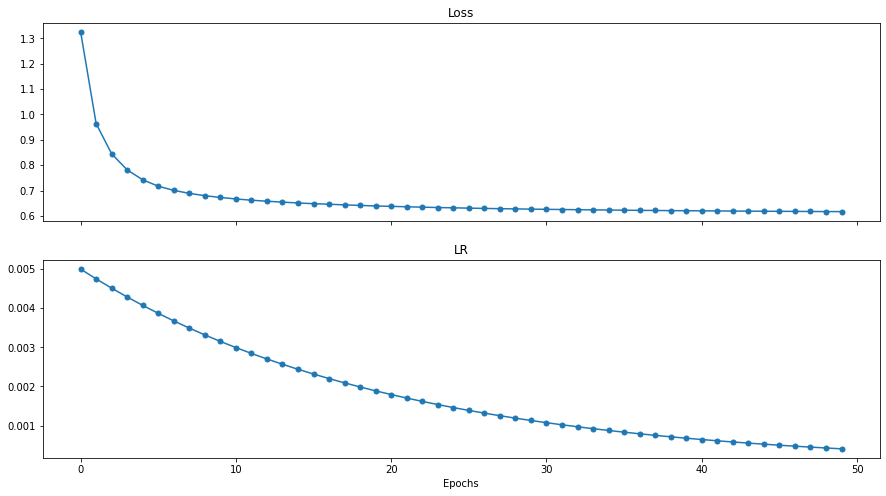

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

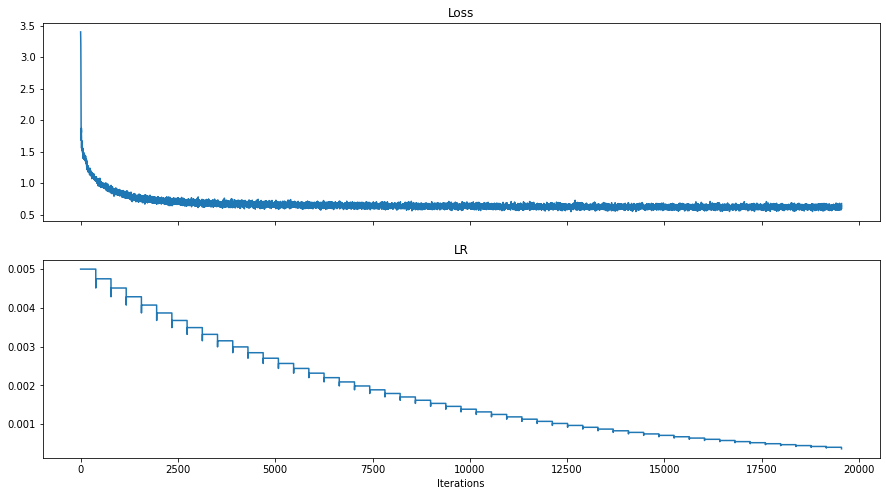

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(iteration_losses[::])
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

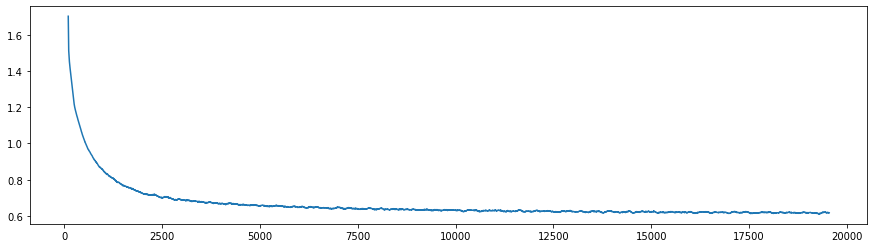

In [ ]:
window = 100
plt.figure(figsize=(15, 4))
pd.Series(iteration_losses).rolling(window=window).mean().iloc[window-1:].plot()
plt.show()

In [ ]:
path = "/content/classifier.pth"
torch.save(model.state_dict(), path)

In [ ]:
path = "/content/classifier.pth"
model = Model(input_size=num_chars, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
names = sampler(model, start='indi', n=10, k=5, only_new=True)
print(names)

['Indi', 'Indiyn', 'Indir', 'Indio', 'Indiay', 'Indiaig', 'Indiona', 'Indiown', 'Indieanegot', 'Indie', 'Indis']


In [ ]:
names = sampler(model, start='herb', n=10, k=5, only_new=False)
print(names)

['Herb', 'Herbngnowds', 'Herbrne', 'Herbr', 'Herbro', 'Herbeyehnno', 'Herbllenato', 'Herbrla', 'Herby', 'Herbe', 'Herbyna']


In [ ]:
names = sampler(model, start='su', n=10, k=5, only_new=True)
print(names)

['Sumiadumias', 'Sulinaenaha', 'Suue', 'Sua', 'Suianootoma', 'Suiauniesos', 'Su', 'Suusssl', 'Suiqkiahhm', 'Suaeni', 'Sucad']


In [ ]:
names = sampler(model, start='vis', n=10, k=5, only_new=True)
print(names)

['Visyo', 'Visillys', 'Vis', 'Viso', 'Visinomiana', 'Vislm', 'Visowds', 'Visyni', 'Vismyn', 'Visug', 'Visa']


In [ ]:
names = sampler(model, start='a', n=10, k=3, only_new=True)
print(names)

['Aaniell', 'Alind', 'Ay', 'Abalya', 'Atoie', 'Aessumyandr', 'Aalynah', 'Aes', 'Abali', 'Aaryann', 'Atorioc']


In [ ]:
names = sampler(model, start='a', n=10, k=8, only_new=True)
print(names)

['Anar', 'Aeseniekets', 'Aathahamsal', 'Ao', 'Anitaomeyen', 'Agaela', 'Atiur', 'Ainab', 'Aidiiendahk', 'Aloxo', 'Arallyeseey']


In [ ]:
names = sampler(model, start='a', n=10, k=15, only_new=True)
print(names)

['Arqqacynisu', 'Alswms', 'Aonsausoskl', 'Anqoumswsth', 'Auti', 'Ad', 'Abo', 'Arancc', 'Absthnqwikh', 'Aeammys', 'Aghkrj']


In [ ]:
names = sampler(model, start='jam', n=10, k=2, only_new=False)
print(names)

['Jaml', 'Jamllene', 'Jam', 'Jame', 'Jams', 'Jamsona', 'Jamso', 'Jamllenea', 'Jamelahina', 'Jamel', 'Jamson']
